In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Loading & Preprocessing



In [ ]:
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from numpy import moveaxis
from numpy import asarray
import pandas as pd
from keras.applications.vgg19 import VGG19
from keras.preprocessing import image
from keras.applications.vgg19 import preprocess_input
from tensorflow.keras.applications import ResNet152V2

In [ ]:
def extractThree(x):
  mid = len(x) // 2
  
  return np.array([ x[mid-1] , x[mid] ,x[mid+1]])
  

In [ ]:
def getTrainingData(type1,type2):

  list = []

  for filename in sorted(os.listdir("/content/drive/My Drive/MRNet-v1.0/"+type1+"/"+type2)):
    if(filename != ".DS_Store"):
      trainingExample = np.load("/content/drive/My Drive/MRNet-v1.0/"+type1+"/"+type2+"/" + filename)
      x = image.img_to_array(trainingExample)
      x = np.expand_dims(x, axis=0)
      x = preprocess_input(x)

      list.append(extractThree(trainingExample))

  return list.copy()
    
    
sagittalTrainingData = getTrainingData("train","sagittal")
axialTrainingData = getTrainingData("train","axial")
coronalTrainingData = getTrainingData("train","coronal")

sagittalTestData = getTrainingData("valid","sagittal")
axialTestData = getTrainingData("valid","axial")
coronalTestData = getTrainingData("valid","coronal")


In [ ]:
def reshape_data(trainingData):
  data = asarray(trainingData)
  data = moveaxis(data, 1, 3)
  print(data.shape)

  return data
  


In [ ]:
sagittalData  = reshape_data(sagittalTrainingData)
axialData = reshape_data(axialTrainingData)
coronalData = reshape_data(coronalTrainingData)

sagittalTestData = reshape_data(sagittalTestData)
axialTestData = reshape_data(axialTestData)
coronalTestData = reshape_data(coronalTestData)


(1130, 256, 256, 3)
(1130, 256, 256, 3)
(1130, 256, 256, 3)
(120, 256, 256, 3)
(120, 256, 256, 3)
(120, 256, 256, 3)


In [ ]:
def readLabels(type1,type2):
  path = "/content/drive/My Drive/MRNet-v1.0/"+type1+"-"+type2 + ".csv"
  df=pd.read_csv(path, sep=',',header=None)
  labelsValid = df.values
  labelsValid = labelsValid[:,1]
  return labelsValid


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score 


def getEvaluationScore(labels,predictions):

  my_score = accuracy_score(labels, predictions)
  print("my score: ",my_score)


  fscore = f1_score(labels, predictions)
  
  print("fscore: ",fscore)
  
  return my_score
  

In [ ]:
def predictLabels(data,model,threshold):
  labels = model.predict(data) 
  for i in labels:
    print(i)
    
  labels = list(map(lambda x: 0 if x<threshold else 1, labels))
  print(labels)
  return labels

In [ ]:
abnormalLabels = readLabels('train','abnormal')
aclLabels = readLabels('train','acl')
meniscusLabels = readLabels('train','meniscus')


abnornmalTestLabels = readLabels('valid','abnormal')
aclTestLabels = readLabels('valid','acl')
meniscusTestLabels = readLabels('valid','meniscus')

## VGG19

In [ ]:
from keras import models
from keras import layers
from keras.models import Model
from keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from keras.applications.vgg19 import VGG19

def buildvgg19Model():
  vgg19 = VGG19(include_top=False, weights='imagenet', input_tensor=None, input_shape=(256,256,3), pooling=None)

  for layer in vgg19.layers:
    layer.trainable = False

  x = vgg19.output
  x = layers.GlobalAveragePooling2D()(x)
  x = layers.Dropout(0.6)(x)
  predictions = layers.Dense(1, activation= 'sigmoid')(x)
  model = Model(inputs = vgg19.input, outputs = predictions)

  model.summary()

  model.compile(loss='binary_crossentropy',optimizer="adam",metrics=['accuracy'])
  return model


### Model Building & Testing For Abnormal

In [ ]:
vgg19model_abnormal_sagittal = buildvgg19Model()
vgg19history_abnormal_sagittal = vgg19model_abnormal_sagittal.fit(sagittalData,abnormalLabels,epochs=500,validation_split=0.1, verbose=1,shuffle=True)

vgg19model_abnormal_axial = buildvgg19Model()
vgg19history_abnormal_axial = vgg19model_abnormal_axial.fit(axialData,abnormalLabels,epochs=500,validation_split=0.1, verbose=1,shuffle=True)

vgg19model_abnormal_coronal = buildvgg19Model()
vgg19history_abnormal_coronal = vgg19model_abnormal_coronal.fit(coronalData,abnormalLabels,epochs=500,validation_split=0.1, verbose=1,shuffle=True)

80150528/80134624 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
______________________________________________________________

### Model Building & Testing For ACL

In [ ]:
vgg19model_acl_sagittal = buildvgg19Model()
vgg19history_acl_sagittal = vgg19model_acl_sagittal.fit(sagittalData,aclLabels,epochs=500,validation_split=0.1, verbose=1,shuffle=True)

vgg19model_acl_axial = buildvgg19Model()
vgg19history_acl_axial = vgg19model_acl_axial.fit(axialData,aclLabels,epochs=500,validation_split=0.1, verbose=1,shuffle=True)

vgg19model_acl_coronal = buildvgg19Model()
vgg19history_acl_coronal = vgg19model_acl_coronal.fit(coronalData,aclLabels,epochs=500,validation_split=0.1, verbose=1,shuffle=True)


Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0   

### Model Building & Testing For Meniscus

In [ ]:
vgg19model_meniscus_sagittal = buildvgg19Model()
vgg19history_meniscus_sagittal = vgg19model_meniscus_sagittal.fit(sagittalData,meniscusLabels,epochs=500,validation_split=0.1, verbose=1,shuffle=True)

vgg19model_meniscus_axial = buildvgg19Model()
vgg19history_meniscus_axial = vgg19model_meniscus_axial.fit(axialData,meniscusLabels,epochs=500,validation_split=0.1, verbose=1,shuffle=True)

vgg19model_meniscus_coronal = buildvgg19Model()
vgg19history_meniscus_coronal = vgg19model_meniscus_coronal.fit(coronalData,meniscusLabels,epochs=500,validation_split=0.1, verbose=1,shuffle=True)


Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0   

### Testing Individual Class

In [ ]:
vgg19predictions_abnormal_sagittal = predictLabels(sagittalTestData,vgg19model_abnormal_sagittal, 0.75)
print("---------------------------------------------------------------------------------")
vgg19predictions_abnormal_axial = predictLabels(axialTestData,vgg19model_abnormal_axial, 0.75)
print("---------------------------------------------------------------------------------")
vgg19predictions_abnormal_coronal = predictLabels(coronalTestData,vgg19model_abnormal_coronal, 0.75)

print("############################################")
vgg19predictions_acl_sagittal = predictLabels(sagittalTestData,vgg19model_acl_sagittal, 0.15)
print("---------------------------------------------------------------------------------")
vgg19predictions_acl_axial = predictLabels(axialTestData,vgg19model_acl_axial, 0.15)
print("---------------------------------------------------------------------------------")
vgg19predictions_acl_coronal = predictLabels(coronalTestData,vgg19model_acl_coronal, 0.15)

print("############################################")
vgg19predictions_meniscus_sagittal = predictLabels(sagittalTestData,vgg19model_meniscus_sagittal, 0.4)
print("---------------------------------------------------------------------------------")
vgg19predictions_meniscus_axial = predictLabels(axialTestData,vgg19model_meniscus_axial, 0.4)
print("---------------------------------------------------------------------------------")
vgg19predictions_meniscus_coronal = predictLabels(coronalTestData,vgg19model_meniscus_coronal, 0.4)

[0.68247217]
[0.86233395]
[0.2752199]
[0.3711733]
[0.8085207]
[0.947072]
[0.87662977]
[0.9627282]
[0.80429316]
[0.67275006]
[0.9618182]
[0.87579155]
[0.9268061]
[0.76219267]
[0.8238873]
[0.92952436]
[0.48017272]
[0.50384486]
[0.8718298]
[0.31596762]
[0.85986173]
[0.88632333]
[0.7595756]
[0.3848652]
[0.9351492]
[0.90969205]
[0.9829844]
[0.9536303]
[0.93119407]
[0.8348766]
[0.99235994]
[0.84882265]
[0.9842479]
[0.9673693]
[0.6620255]
[0.8326218]
[0.965309]
[0.9757429]
[0.7546161]
[0.8844063]
[0.9146935]
[0.97142416]
[0.9694986]
[0.9891368]
[0.73302525]
[0.9987218]
[0.92999214]
[0.90009594]
[0.99508375]
[0.97391915]
[0.9838726]
[0.9302602]
[0.97103465]
[0.9962042]
[0.9912367]
[0.9225577]
[0.9737322]
[0.9986519]
[0.9804654]
[0.8824119]
[0.99604815]
[0.9721038]
[0.9398834]
[0.9883809]
[0.9879169]
[0.98958755]
[0.99870396]
[0.8616124]
[0.8981227]
[0.9911247]
[0.87903976]
[0.9848231]
[0.93987364]
[0.9562734]
[0.9938466]
[0.95471346]
[0.9803713]
[0.93817455]
[0.87833357]
[0.95885366]
[0.977767

### Final Prediction

In [ ]:
def ensemble(predictions1,predictions2,predictions3):
  list=[]
  for i in range(0,len(predictions1),1):
    total = sum([predictions1[i],predictions2[i],predictions3[i]])
    if total > 1:
      list.append(1)
    else:
      list.append(0)
      
  return list.copy()

vgg19labels_abnormal_ensemble = ensemble(vgg19predictions_abnormal_sagittal,vgg19predictions_abnormal_axial,vgg19predictions_abnormal_coronal)
print("labels_abnormal_ensemble: ",vgg19labels_abnormal_ensemble)
vgg19score_abnormal = getEvaluationScore(abnornmalTestLabels, vgg19labels_abnormal_ensemble)


vgg19labels_acl_ensemble = ensemble(vgg19predictions_acl_sagittal,vgg19predictions_acl_axial,vgg19predictions_acl_coronal)
print("labels_acl_ensemble: ",vgg19labels_acl_ensemble)
vgg19score_acl = getEvaluationScore(aclTestLabels, vgg19labels_acl_ensemble)



vgg19labels_meniscus_ensemble = ensemble(vgg19predictions_meniscus_sagittal,vgg19predictions_meniscus_axial,vgg19predictions_meniscus_coronal)
print("labels_meniscus_ensemble: ",vgg19labels_meniscus_ensemble)
vgg19score_meniscus = getEvaluationScore(meniscusTestLabels, vgg19labels_meniscus_ensemble)

labels_abnormal_ensemble:  [0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
my score:  0.875
fscore:  0.9246231155778896
labels_acl_ensemble:  [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0]
my score:  0.8
fscore:  0.7818181818181819
labels_meniscus_ensemble:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0,

In [ ]:
score1 = getEvaluationScore(abnornmalTestLabels, vgg19predictions_abnormal_sagittal)
score2 = getEvaluationScore(abnornmalTestLabels, vgg19predictions_abnormal_axial)
score3 = getEvaluationScore(abnornmalTestLabels, vgg19predictions_abnormal_coronal)

NameError: ignored

In [ ]:
score1 = getEvaluationScore(aclTestLabels, vgg19predictions_acl_sagittal)
score2 = getEvaluationScore(aclTestLabels, vgg19predictions_acl_axial)
score3 = getEvaluationScore(aclTestLabels, vgg19predictions_acl_coronal)

In [ ]:
score1 = getEvaluationScore(meniscusTestLabels, vgg19predictions_meniscus_sagittal)
score2 = getEvaluationScore(meniscusTestLabels, vgg19predictions_meniscus_axial)
score3 = getEvaluationScore(meniscusTestLabels, vgg19predictions_meniscus_coronal)

### Training Acc & Loss Graphs

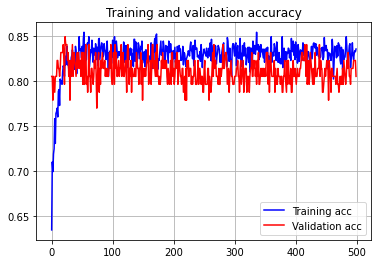

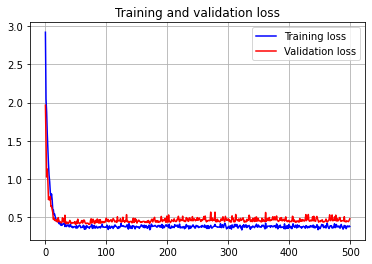

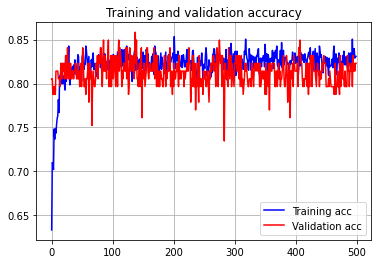

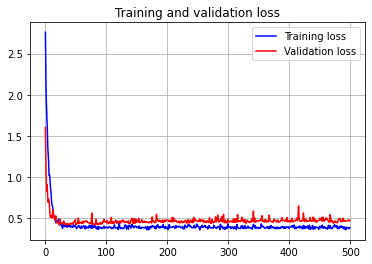

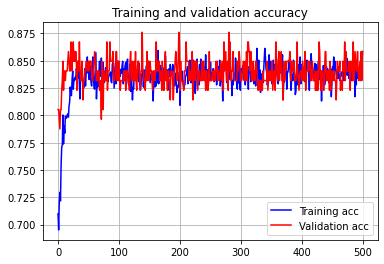

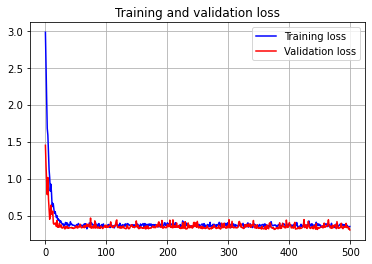

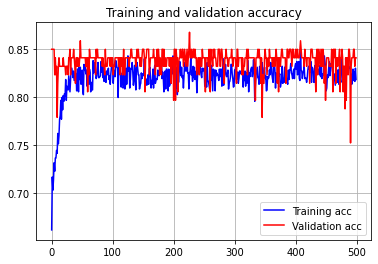

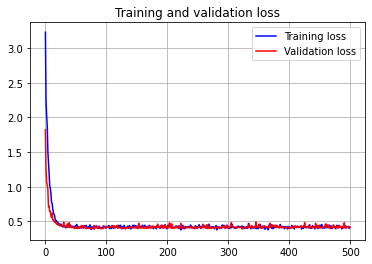

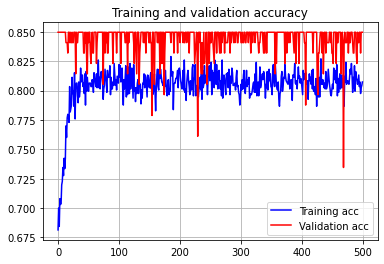

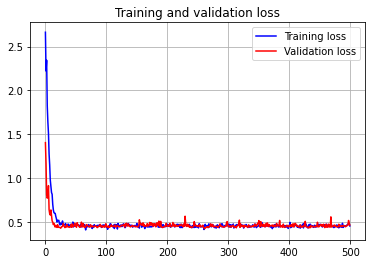

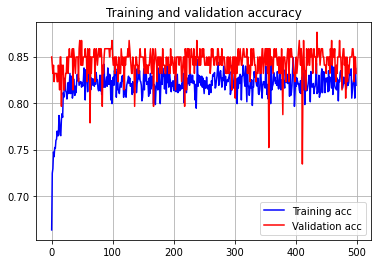

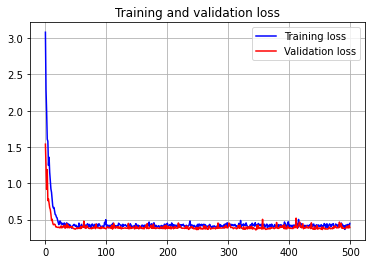

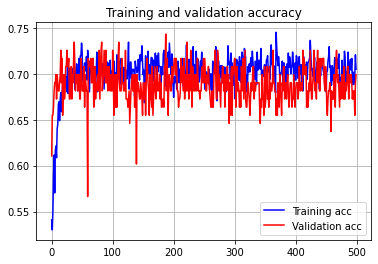

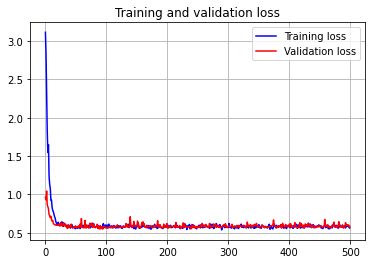

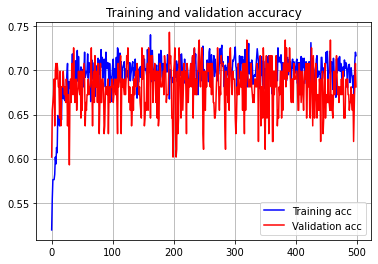

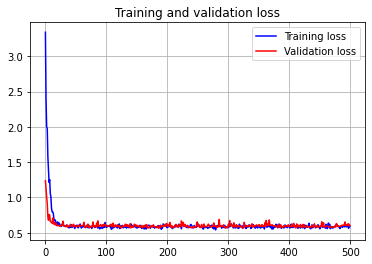

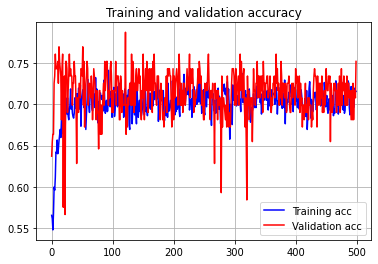

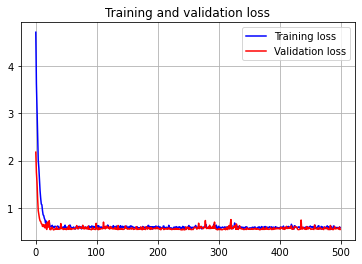

In [ ]:
def plot_accuracy(history):  
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'b', label='Training acc')
  plt.plot(epochs, val_acc, 'r', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.grid(True)

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()
  plt.grid(True)
  plt.show()

  
plot_accuracy(vgg19history_abnormal_sagittal)
plot_accuracy(vgg19history_abnormal_coronal)
plot_accuracy(vgg19history_abnormal_axial)

plot_accuracy(vgg19history_acl_sagittal)
plot_accuracy(vgg19history_acl_coronal)
plot_accuracy(vgg19history_acl_axial)

plot_accuracy(vgg19history_meniscus_sagittal)
plot_accuracy(vgg19history_meniscus_coronal)
plot_accuracy(vgg19history_meniscus_axial)

##VGG16


In [ ]:
from keras import models
from keras import layers
from keras.models import Model
from keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from keras.applications.vgg16 import VGG16

def buildvggModel():
  vgg = VGG16(include_top=False, weights='imagenet', input_tensor=None, input_shape=(256,256,3), pooling=None)

  for layer in vgg.layers:
    layer.trainable = False

  x = vgg.output
  x = layers.GlobalAveragePooling2D()(x)
  x = layers.Dropout(0.6)(x)
  predictions = layers.Dense(1, activation= 'sigmoid')(x)
  model = Model(inputs = vgg.input, outputs = predictions)

  model.summary()

  model.compile(loss='binary_crossentropy',optimizer="adam",metrics=['accuracy'])
  return model



### Model Building & Testing For Abnormal

In [ ]:
vggmodel_abnormal_sagittal = buildvggModel()
vgghistory_abnormal_sagittal = vggmodel_abnormal_sagittal.fit(sagittalData,abnormalLabels,epochs=500,validation_split=0.1, verbose=1,shuffle=True)

vggmodel_abnormal_axial = buildvggModel()
vgghistory_abnormal_axial = vggmodel_abnormal_axial.fit(axialData,abnormalLabels,epochs=500,validation_split=0.1, verbose=1,shuffle=True)

vggmodel_abnormal_coronal = buildvggModel()
vgghistory_abnormal_coronal = vggmodel_abnormal_coronal.fit(coronalData,abnormalLabels,epochs=500,validation_split=0.1, verbose=1,shuffle=True)


58900480/58889256 [==============================] - 0s 0us/step
Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
___________________________________________________________

### Model Building & Testing For ACL

In [ ]:
vggmodel_acl_sagittal = buildvggModel()
vgghistory_acl_sagittal = vggmodel_acl_sagittal.fit(sagittalData,aclLabels,epochs=500,validation_split=0.1, verbose=1,shuffle=True)

vggmodel_acl_axial = buildvggModel()
vgghistory_acl_axial = vggmodel_acl_axial.fit(axialData,aclLabels,epochs=500,validation_split=0.1, verbose=1,shuffle=True)

vggmodel_acl_coronal = buildvggModel()
vgghistory_acl_coronal = vggmodel_acl_coronal.fit(coronalData,aclLabels,epochs=500,validation_split=0.1, verbose=1,shuffle=True)


Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0  

### Model Building & Testing For Meniscus

In [ ]:
vggmodel_meniscus_sagittal = buildvggModel()
vgghistory_meniscus_sagittal = vggmodel_meniscus_sagittal.fit(sagittalData,meniscusLabels,epochs=500,validation_split=0.1, verbose=1,shuffle=True)

vggmodel_meniscus_axial = buildvggModel()
vgghistory_meniscus_axial = vggmodel_meniscus_axial.fit(axialData,meniscusLabels,epochs=500,validation_split=0.1, verbose=1,shuffle=True)

vggmodel_meniscus_coronal = buildvggModel()
vgghistory_meniscus_coronal = vggmodel_meniscus_coronal.fit(coronalData,meniscusLabels,epochs=500,validation_split=0.1, verbose=1,shuffle=True)


Model: "model_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0  

### Testing Individual Class

In [ ]:
vggpredictions_abnormal_sagittal = predictLabels(sagittalTestData,vggmodel_abnormal_sagittal, 0.75)
print("---------------------------------------------------------------------------------")
vggpredictions_abnormal_axial = predictLabels(axialTestData,vggmodel_abnormal_axial, 0.75)
print("---------------------------------------------------------------------------------")
vggpredictions_abnormal_coronal = predictLabels(coronalTestData,vggmodel_abnormal_coronal, 0.75)

print("############################################")
vggpredictions_acl_sagittal = predictLabels(sagittalTestData,vggmodel_acl_sagittal, 0.15)
print("---------------------------------------------------------------------------------")
vggpredictions_acl_axial = predictLabels(axialTestData,vggmodel_acl_axial, 0.15)
print("---------------------------------------------------------------------------------")
vggpredictions_acl_coronal = predictLabels(coronalTestData,vggmodel_acl_coronal, 0.15)

print("############################################")
vggpredictions_meniscus_sagittal = predictLabels(sagittalTestData,vggmodel_meniscus_sagittal, 0.4)
print("---------------------------------------------------------------------------------")
vggpredictions_meniscus_axial = predictLabels(axialTestData,vggmodel_meniscus_axial, 0.4)
print("---------------------------------------------------------------------------------")
vggpredictions_meniscus_coronal = predictLabels(coronalTestData,vggmodel_meniscus_coronal, 0.4)

[0.42845014]
[0.74883294]
[0.5658609]
[0.20574602]
[0.7762398]
[0.8042613]
[0.7808849]
[0.9269096]
[0.4581506]
[0.6001008]
[0.9309239]
[0.6850971]
[0.7904848]
[0.17444663]
[0.5292677]
[0.8992457]
[0.6620715]
[0.62412226]
[0.85971445]
[0.32934904]
[0.5966589]
[0.8020615]
[0.38601083]
[0.49752986]
[0.8300539]
[0.8743115]
[0.85157406]
[0.8261218]
[0.9653076]
[0.734889]
[0.91609895]
[0.4196329]
[0.98131233]
[0.9347076]
[0.43242186]
[0.8680821]
[0.97518563]
[0.9152093]
[0.5714256]
[0.86686075]
[0.82516944]
[0.96684444]
[0.9393602]
[0.9413323]
[0.9157338]
[0.81850755]
[0.9492838]
[0.8662937]
[0.9863129]
[0.9731599]
[0.9701268]
[0.8737701]
[0.98111856]
[0.99740845]
[0.9551915]
[0.8831074]
[0.9840777]
[0.9859557]
[0.9560812]
[0.9300212]
[0.93509436]
[0.896954]
[0.8608871]
[0.9582154]
[0.9120191]
[0.948231]
[0.9899086]
[0.7795334]
[0.76915294]
[0.9041284]
[0.70629567]
[0.7824197]
[0.8066152]
[0.9724548]
[0.9868952]
[0.81668717]
[0.98580223]
[0.9495352]
[0.4812797]
[0.8828427]
[0.953644]
[0.9978

### Final Prediction

In [ ]:
def ensemble(predictions1,predictions2,predictions3):
  list=[]
  for i in range(0,len(predictions1),1):
    total = sum([predictions1[i],predictions2[i],predictions3[i]])
    if total > 1:
      list.append(1)
    else:
      list.append(0)
      
  return list.copy()

vgglabels_abnormal_ensemble = ensemble(vggpredictions_abnormal_sagittal,vggpredictions_abnormal_axial,vggpredictions_abnormal_coronal)
print("labels_abnormal_ensemble: ",vgglabels_abnormal_ensemble)
vggscore_abnormal = getEvaluationScore(abnornmalTestLabels, vgglabels_abnormal_ensemble)


vgglabels_acl_ensemble = ensemble(vggpredictions_acl_sagittal,vggpredictions_acl_axial,vggpredictions_acl_coronal)
print("labels_acl_ensemble: ",vgglabels_acl_ensemble)
vggscore_acl = getEvaluationScore(aclTestLabels, vgglabels_acl_ensemble)



vgglabels_meniscus_ensemble = ensemble(vggpredictions_meniscus_sagittal,vggpredictions_meniscus_axial,vggpredictions_meniscus_coronal)
print("labels_meniscus_ensemble: ",vgglabels_meniscus_ensemble)
vggscore_meniscus = getEvaluationScore(meniscusTestLabels, vgglabels_meniscus_ensemble)

    


labels_abnormal_ensemble:  [0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]
my score:  0.8416666666666667
fscore:  0.9025641025641025
labels_acl_ensemble:  [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1]
my score:  0.775
fscore:  0.7652173913043478
labels_meniscus_ensemble:  [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1,

## Training Acc & Loss Graphs

In [ ]:
def plot_accuracy(history):  
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'b', label='Training acc')
  plt.plot(epochs, val_acc, 'r', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.grid(True)

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()
  plt.grid(True)
  plt.show()

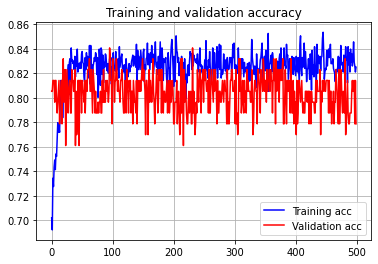

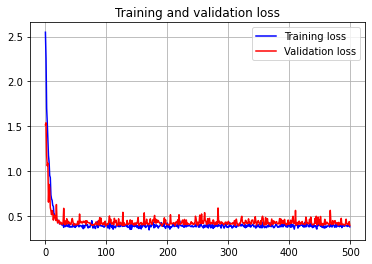

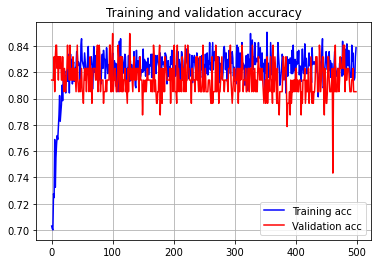

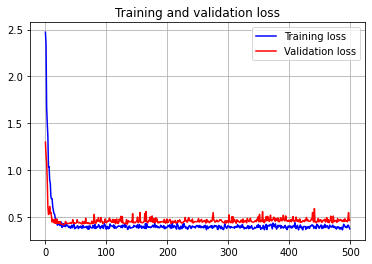

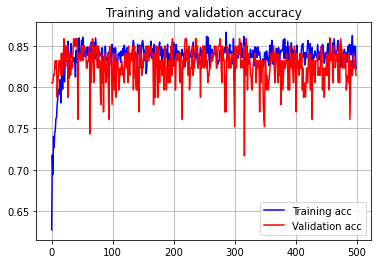

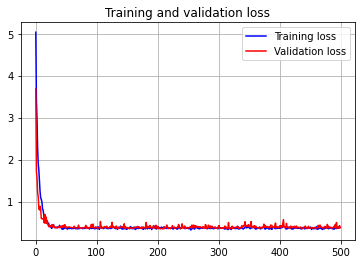

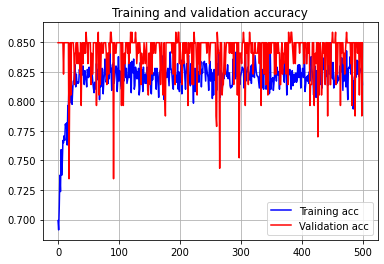

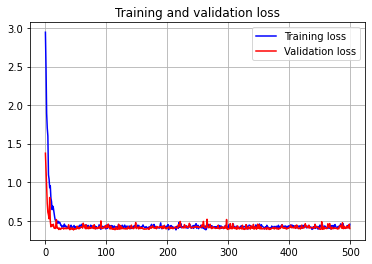

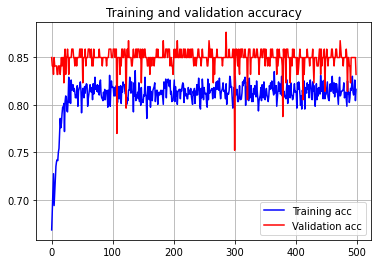

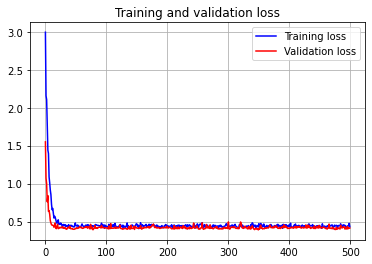

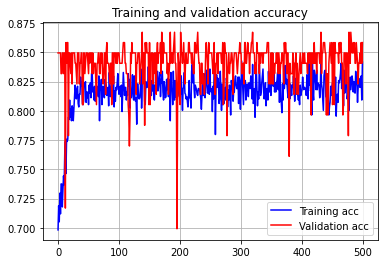

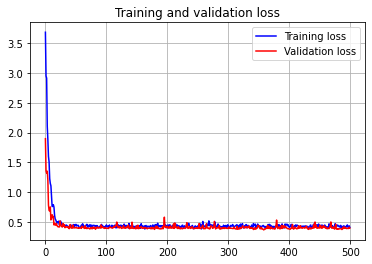

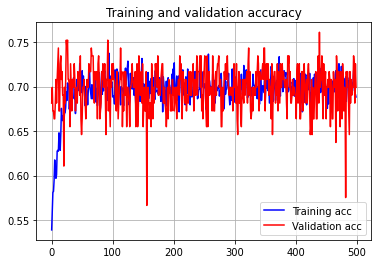

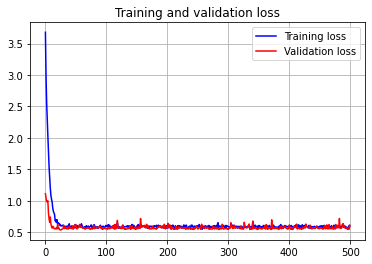

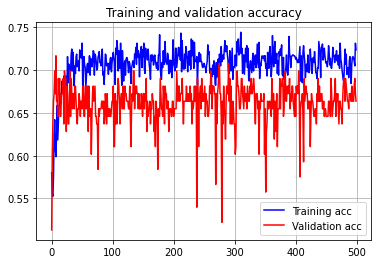

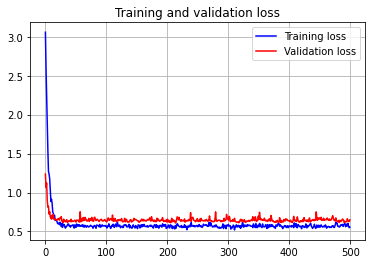

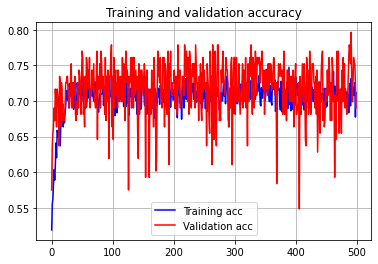

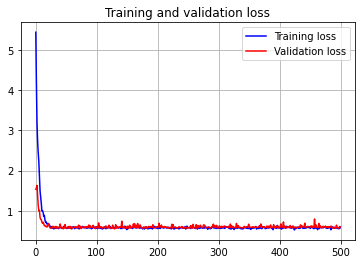

In [ ]:

plot_accuracy(vgghistory_abnormal_sagittal)
plot_accuracy(vgghistory_abnormal_coronal)
plot_accuracy(vgghistory_abnormal_axial)

plot_accuracy(vgghistory_acl_sagittal)
plot_accuracy(vgghistory_acl_coronal)
plot_accuracy(vgghistory_acl_axial)

plot_accuracy(vgghistory_meniscus_sagittal)
plot_accuracy(vgghistory_meniscus_coronal)
plot_accuracy(vgghistory_meniscus_axial)


#  ResNet152V2

In [ ]:
from keras import models
from keras import layers
from keras.models import Model
from keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from keras.applications.resnet import ResNet152

def buildresModel():
  res = ResNet152(include_top=False, weights='imagenet', input_tensor=None, input_shape=(256,256,3), pooling=None)

  for layer in res.layers:
    layer.trainable = False

  x = res.output
  x = layers.GlobalAveragePooling2D()(x)
  x = layers.Dropout(0.6)(x)
  predictions = layers.Dense(1, activation= 'sigmoid')(x)
  model = Model(inputs = res.input, outputs = predictions)

  model.summary()

  model.compile(loss='binary_crossentropy',optimizer="adam",metrics=['accuracy'])
  return model

## Model Building & Testing For Abnormal

In [ ]:
resmodel_abnormal_sagittal = buildresModel()
reshistory_abnormal_sagittal = resmodel_abnormal_sagittal.fit(sagittalData,abnormalLabels,epochs=500,validation_split=0.1, verbose=1,shuffle=True)

resmodel_abnormal_axial = buildresModel()
reshistory_abnormal_axial = resmodel_abnormal_axial.fit(axialData,abnormalLabels,epochs=500,validation_split=0.1, verbose=1,shuffle=True)

resmodel_abnormal_coronal = buildresModel()
reshistory_abnormal_coronal = resmodel_abnormal_coronal.fit(coronalData,abnormalLabels,epochs=500,validation_split=0.1, verbose=1,shuffle=True)

Streaming output truncated to the last 5000 lines.
Epoch 95/500
32/32 [==============================] - 5s 170ms/step - loss: 0.3068 - accuracy: 0.8813 - val_loss: 0.3705 - val_accuracy: 0.8319
Epoch 96/500
32/32 [==============================] - 5s 169ms/step - loss: 0.2861 - accuracy: 0.8821 - val_loss: 0.3661 - val_accuracy: 0.7965
Epoch 97/500
32/32 [==============================] - 5s 169ms/step - loss: 0.2839 - accuracy: 0.8663 - val_loss: 0.3661 - val_accuracy: 0.8053
Epoch 98/500
32/32 [==============================] - 5s 169ms/step - loss: 0.3191 - accuracy: 0.8547 - val_loss: 0.3630 - val_accuracy: 0.8053
Epoch 99/500
32/32 [==============================] - 5s 169ms/step - loss: 0.3135 - accuracy: 0.8686 - val_loss: 0.3978 - val_accuracy: 0.8230
Epoch 100/500
32/32 [==============================] - 5s 169ms/step - loss: 0.3267 - accuracy: 0.8502 - val_loss: 0.4304 - val_accuracy: 0.8142
Epoch 101/500
32/32 [==============================] - 5s 169ms/step - loss: 0.3329 

## Model Building & Testing For ACL

In [ ]:
resmodel_acl_sagittal = buildresModel()
reshistory_acl_sagittal = resmodel_acl_sagittal.fit(sagittalData,aclLabels,epochs=500,validation_split=0.1, verbose=1,shuffle=True)

resmodel_acl_axial = buildresModel()
reshistory_acl_axial = resmodel_acl_axial.fit(axialData,aclLabels,epochs=500,validation_split=0.1, verbose=1,shuffle=True)

resmodel_acl_coronal = buildresModel()
reshistory_acl_coronal = resmodel_acl_coronal.fit(coronalData,aclLabels,epochs=500,validation_split=0.1, verbose=1,shuffle=True)


Streaming output truncated to the last 5000 lines.
Epoch 87/500
32/32 [==============================] - 5s 170ms/step - loss: 0.2980 - accuracy: 0.8644 - val_loss: 0.4170 - val_accuracy: 0.8319
Epoch 88/500
32/32 [==============================] - 5s 170ms/step - loss: 0.3258 - accuracy: 0.8590 - val_loss: 0.4208 - val_accuracy: 0.8584
Epoch 89/500
32/32 [==============================] - 5s 170ms/step - loss: 0.3120 - accuracy: 0.8605 - val_loss: 0.4229 - val_accuracy: 0.8230
Epoch 90/500
32/32 [==============================] - 5s 170ms/step - loss: 0.3549 - accuracy: 0.8519 - val_loss: 0.4141 - val_accuracy: 0.8496
Epoch 91/500
32/32 [==============================] - 5s 170ms/step - loss: 0.3167 - accuracy: 0.8609 - val_loss: 0.4132 - val_accuracy: 0.8407
Epoch 92/500
32/32 [==============================] - 5s 170ms/step - loss: 0.3541 - accuracy: 0.8379 - val_loss: 0.4118 - val_accuracy: 0.8584
Epoch 93/500
32/32 [==============================] - 5s 170ms/step - loss: 0.3359 - 

KeyboardInterrupt: ignored

## Model Building & Testing For Meniscus

In [ ]:
resmodel_meniscus_sagittal = buildresModel()
reshistory_meniscus_sagittal = resmodel_meniscus_sagittal.fit(sagittalData,meniscusLabels,epochs=500,validation_split=0.1, verbose=1,shuffle=True)

resmodel_meniscus_axial = buildresModel()
reshistory_meniscus_axial = resmodel_meniscus_axial.fit(axialData,meniscusLabels,epochs=500,validation_split=0.1, verbose=1,shuffle=True)

resmodel_meniscus_coronal = buildresModel()
reshistory_meniscus_coronal = resmodel_meniscus_coronal.fit(coronalData,meniscusLabels,epochs=500,validation_split=0.1, verbose=1,shuffle=True)


## Testing Individual Class

In [ ]:
respredictions_abnormal_sagittal = predictLabels(sagittalTestData,resmodel_abnormal_sagittal, 0.75)
print("---------------------------------------------------------------------------------")
respredictions_abnormal_axial = predictLabels(axialTestData,resmodel_abnormal_axial, 0.75)
print("---------------------------------------------------------------------------------")
respredictions_abnormal_coronal = predictLabels(coronalTestData,resmodel_abnormal_coronal, 0.75)

print("############################################")
respredictions_acl_sagittal = predictLabels(sagittalTestData,resmodel_acl_sagittal, 0.15)
print("---------------------------------------------------------------------------------")
respredictions_acl_axial = predictLabels(axialTestData,resmodel_acl_axial, 0.15)
print("---------------------------------------------------------------------------------")
respredictions_acl_coronal = predictLabels(coronalTestData,resmodel_acl_coronal, 0.15)

print("############################################")
respredictions_meniscus_sagittal = predictLabels(sagittalTestData,resmodel_meniscus_sagittal, 0.4)
print("---------------------------------------------------------------------------------")
respredictions_meniscus_axial = predictLabels(axialTestData,resmodel_meniscus_axial, 0.4)
print("---------------------------------------------------------------------------------")
respredictions_meniscus_coronal = predictLabels(coronalTestData,resmodel_meniscus_coronal, 0.4)

## Final Prediction

In [ ]:
def ensemble(predictions1,predictions2,predictions3):
  list=[]
  for i in range(0,len(predictions1),1):
    total = sum([predictions1[i],predictions2[i],predictions3[i]])
    if total > 1:
      list.append(1)
    else:
      list.append(0)
      
  return list.copy()

reslabels_abnormal_ensemble = ensemble(respredictions_abnormal_sagittal,respredictions_abnormal_axial,respredictions_abnormal_coronal)
print("labels_abnormal_ensemble: ",reslabels_abnormal_ensemble)
resscore_abnormal = getEvaluationScore(abnornmalTestLabels, reslabels_abnormal_ensemble)


reslabels_acl_ensemble = ensemble(respredictions_acl_sagittal,respredictions_acl_axial,respredictions_acl_coronal)
print("labels_acl_ensemble: ",reslabels_acl_ensemble)
resscore_acl = getEvaluationScore(aclTestLabels, reslabels_acl_ensemble)



reslabels_meniscus_ensemble = ensemble(respredictions_meniscus_sagittal,respredictions_meniscus_axial,respredictions_meniscus_coronal)
print("labels_meniscus_ensemble: ",reslabels_meniscus_ensemble)
resscore_meniscus = getEvaluationScore(meniscusTestLabels, reslabels_meniscus_ensemble)

In [ ]:
score1 = getEvaluationScore(abnornmalTestLabels, respredictions_abnormal_sagittal)
score2 = getEvaluationScore(abnornmalTestLabels, respredictions_abnormal_axial)
score3 = getEvaluationScore(abnornmalTestLabels, respredictions_abnormal_coronal)

In [ ]:
score1 = getEvaluationScore(aclTestLabels, respredictions_acl_sagittal)
score2 = getEvaluationScore(aclTestLabels, respredictions_acl_axial)
score3 = getEvaluationScore(aclTestLabels, respredictions_acl_coronal)

my score:  0.7833333333333333
fscore:  0.7547169811320754
my score:  0.7666666666666667
fscore:  0.7543859649122806
my score:  0.7166666666666667
fscore:  0.6909090909090909


In [ ]:
score1 = getEvaluationScore(meniscusTestLabels, respredictions_meniscus_sagittal)
score2 = getEvaluationScore(meniscusTestLabels, respredictions_meniscus_axial)
score3 = getEvaluationScore(meniscusTestLabels, respredictions_meniscus_coronal)

my score:  0.6083333333333333
fscore:  0.6356589147286822
my score:  0.6083333333333333
fscore:  0.5436893203883495
my score:  0.65
fscore:  0.5961538461538461


## Training Acc & Loss Graphs

In [ ]:
def plot_accuracy(history):  
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'b', label='Training acc')
  plt.plot(epochs, val_acc, 'r', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.grid(True)

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()
  plt.grid(True)
  plt.show()

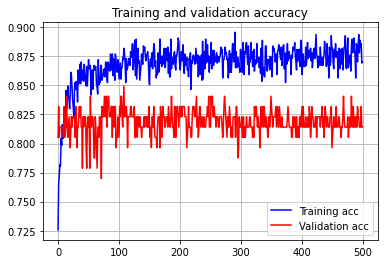

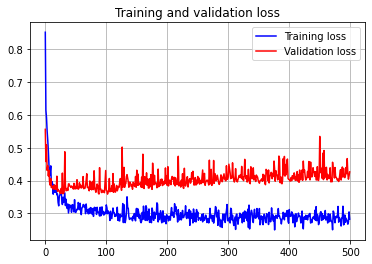

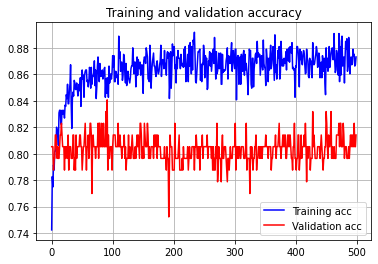

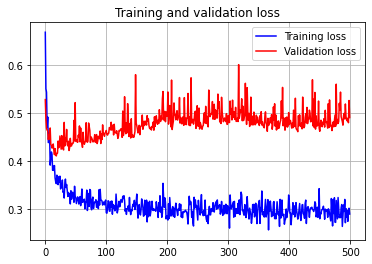

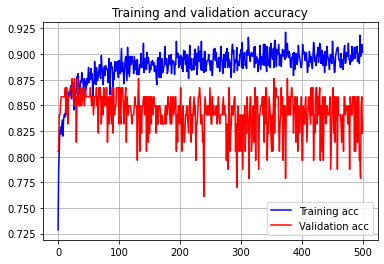

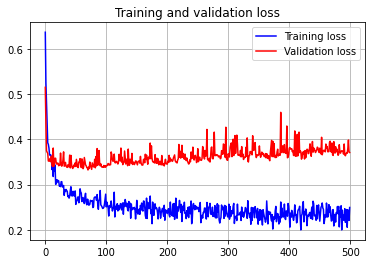

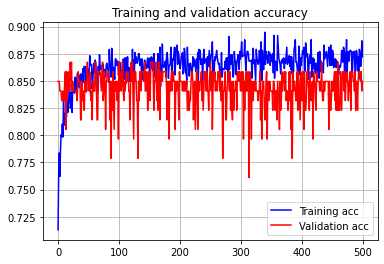

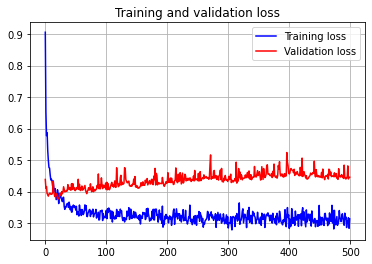

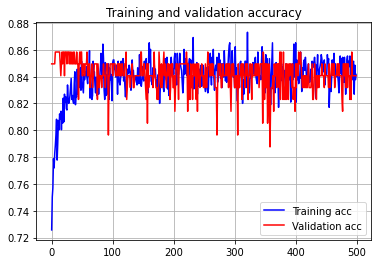

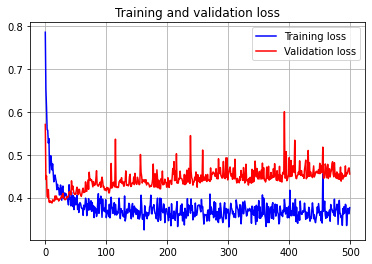

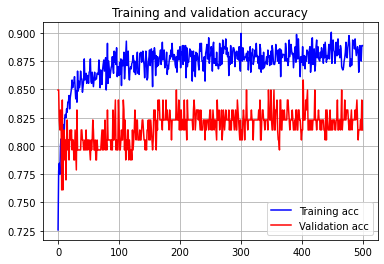

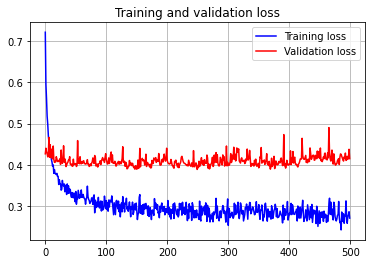

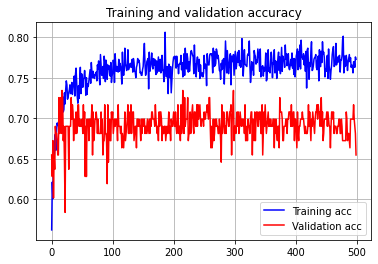

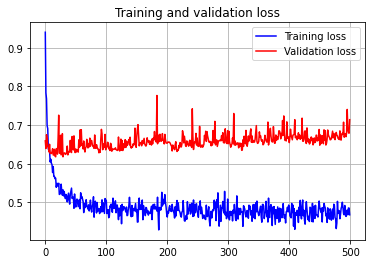

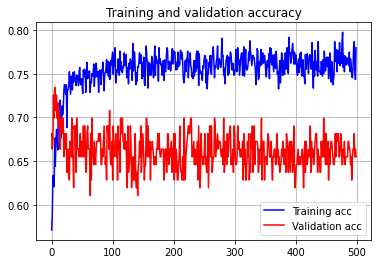

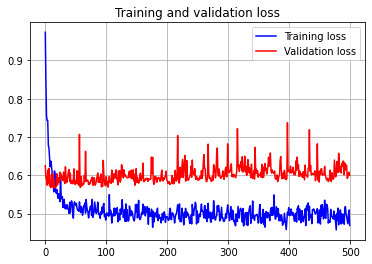

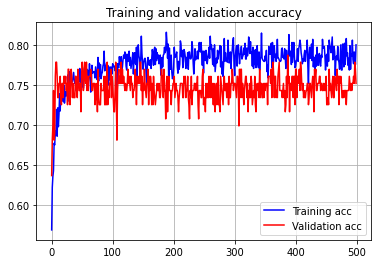

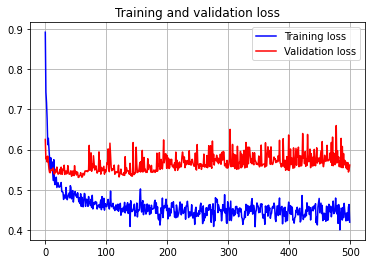

In [ ]:
plot_accuracy(reshistory_abnormal_sagittal)
plot_accuracy(reshistory_abnormal_coronal)
plot_accuracy(reshistory_abnormal_axial)

plot_accuracy(reshistory_acl_sagittal)
plot_accuracy(reshistory_acl_coronal)
plot_accuracy(reshistory_acl_axial)

plot_accuracy(reshistory_meniscus_sagittal)
plot_accuracy(reshistory_meniscus_coronal)
plot_accuracy(reshistory_meniscus_axial)

# InceptionV3

In [ ]:
from keras import models
from keras import layers
from keras.models import Model
from keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from keras.applications.inception_v3 import InceptionV3

def buildiModel():
  i = InceptionV3(include_top=False, weights='imagenet', input_tensor=None, input_shape=(256,256,3), pooling=None)

  for layer in i.layers:
    layer.trainable = False

  x = i.output
  x = layers.GlobalAveragePooling2D()(x)
  x = layers.Dropout(0.6)(x)
  predictions = layers.Dense(1, activation= 'sigmoid')(x)
  model = Model(inputs = i.input, outputs = predictions)

  model.summary()

  model.compile(loss='binary_crossentropy',optimizer="adam",metrics=['accuracy'])
  return model

## Model Building & Testing For Abnormal

In [ ]:
imodel_abnormal_sagittal = buildiModel()
ihistory_abnormal_sagittal = imodel_abnormal_sagittal.fit(sagittalData,abnormalLabels,epochs=500,validation_split=0.1, verbose=1,shuffle=True)
imodel_abnormal_axial = buildiModel()
ihistory_abnormal_axial = imodel_abnormal_axial.fit(axialData,abnormalLabels,epochs=500,validation_split=0.1, verbose=1,shuffle=True)
imodel_abnormal_coronal = buildiModel()
ihistory_abnormal_coronal = imodel_abnormal_coronal.fit(coronalData,abnormalLabels,epochs=500,validation_split=0.1, verbose=1,shuffle=True)

Streaming output truncated to the last 5000 lines.
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 125, 125, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 125, 125, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 125, 125, 64) 18432       activation_1[0][0]               
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 125, 125, 64) 192         conv2d_2[0][0]                   
__________________________________________________________________________________________________
activation_2 (Activation)       (None, 125, 125, 64) 0    

## Model Building & Testing For ACL

In [ ]:
imodel_acl_sagittal = buildiModel()
ihistory_acl_sagittal = imodel_acl_sagittal.fit(sagittalData,aclLabels,epochs=500,validation_split=0.1, verbose=1,shuffle=True)

imodel_acl_axial = buildiModel()
ihistory_acl_axial = imodel_acl_axial.fit(axialData,aclLabels,epochs=500,validation_split=0.1, verbose=1,shuffle=True)

imodel_acl_coronal = buildiModel()
ihistory_acl_coronal = imodel_acl_coronal.fit(coronalData,aclLabels,epochs=500,validation_split=0.1, verbose=1,shuffle=True)


Streaming output truncated to the last 5000 lines.
__________________________________________________________________________________________________
batch_normalization_283 (BatchN (None, 125, 125, 32) 96          conv2d_283[0][0]                 
__________________________________________________________________________________________________
activation_283 (Activation)     (None, 125, 125, 32) 0           batch_normalization_283[0][0]    
__________________________________________________________________________________________________
conv2d_284 (Conv2D)             (None, 125, 125, 64) 18432       activation_283[0][0]             
__________________________________________________________________________________________________
batch_normalization_284 (BatchN (None, 125, 125, 64) 192         conv2d_284[0][0]                 
__________________________________________________________________________________________________
activation_284 (Activation)     (None, 125, 125, 64) 0    

## Model Building & Testing For Meniscus

In [ ]:
imodel_meniscus_sagittal = buildiModel()
ihistory_meniscus_sagittal = imodel_meniscus_sagittal.fit(sagittalData,meniscusLabels,epochs=500,validation_split=0.1, verbose=1,shuffle=True)

imodel_meniscus_axial = buildiModel()
ihistory_meniscus_axial = imodel_meniscus_axial.fit(axialData,meniscusLabels,epochs=500,validation_split=0.1, verbose=1,shuffle=True)

imodel_meniscus_coronal = buildiModel()
ihistory_meniscus_coronal = imodel_meniscus_coronal.fit(coronalData,meniscusLabels,epochs=500,validation_split=0.1, verbose=1,shuffle=True)


Streaming output truncated to the last 5000 lines.
__________________________________________________________________________________________________
batch_normalization_565 (BatchN (None, 125, 125, 32) 96          conv2d_565[0][0]                 
__________________________________________________________________________________________________
activation_565 (Activation)     (None, 125, 125, 32) 0           batch_normalization_565[0][0]    
__________________________________________________________________________________________________
conv2d_566 (Conv2D)             (None, 125, 125, 64) 18432       activation_565[0][0]             
__________________________________________________________________________________________________
batch_normalization_566 (BatchN (None, 125, 125, 64) 192         conv2d_566[0][0]                 
__________________________________________________________________________________________________
activation_566 (Activation)     (None, 125, 125, 64) 0    

## Testing Individual Class

In [ ]:
ipredictions_abnormal_sagittal = predictLabels(sagittalTestData,imodel_abnormal_sagittal, 0.75)
print("---------------------------------------------------------------------------------")
ipredictions_abnormal_axial = predictLabels(axialTestData,imodel_abnormal_axial, 0.75)
print("---------------------------------------------------------------------------------")
ipredictions_abnormal_coronal = predictLabels(coronalTestData,imodel_abnormal_coronal, 0.75)

print("############################################")
ipredictions_acl_sagittal = predictLabels(sagittalTestData,imodel_acl_sagittal, 0.15)
print("---------------------------------------------------------------------------------")
ipredictions_acl_axial = predictLabels(axialTestData,imodel_acl_axial, 0.15)
print("---------------------------------------------------------------------------------")
ipredictions_acl_coronal = predictLabels(coronalTestData,imodel_acl_coronal, 0.15)

print("############################################")
ipredictions_meniscus_sagittal = predictLabels(sagittalTestData,imodel_meniscus_sagittal, 0.4)
print("---------------------------------------------------------------------------------")
ipredictions_meniscus_axial = predictLabels(axialTestData,imodel_meniscus_axial, 0.4)
print("---------------------------------------------------------------------------------")
ipredictions_meniscus_coronal = predictLabels(coronalTestData,imodel_meniscus_coronal, 0.4)

## Final Prediction

In [ ]:
def ensemble(predictions1,predictions2,predictions3):
  list=[]
  for i in range(0,len(predictions1),1):
    total = sum([predictions1[i],predictions2[i],predictions3[i]])
    if total > 1:
      list.append(1)
    else:
      list.append(0)
      
  return list.copy()

ilabels_abnormal_ensemble = ensemble(ipredictions_abnormal_sagittal,ipredictions_abnormal_axial,ipredictions_abnormal_coronal)
print("labels_abnormal_ensemble: ",ilabels_abnormal_ensemble)
iscore_abnormal = getEvaluationScore(abnornmalTestLabels, ilabels_abnormal_ensemble)


ilabels_acl_ensemble = ensemble(ipredictions_acl_sagittal,ipredictions_acl_axial,ipredictions_acl_coronal)
print("labels_acl_ensemble: ",ilabels_acl_ensemble)
iscore_acl = getEvaluationScore(aclTestLabels, ilabels_acl_ensemble)



ilabels_meniscus_ensemble = ensemble(ipredictions_meniscus_sagittal,ipredictions_meniscus_axial,ipredictions_meniscus_coronal)
print("labels_meniscus_ensemble: ",ilabels_meniscus_ensemble)
iscore_meniscus = getEvaluationScore(meniscusTestLabels, ilabels_meniscus_ensemble)

labels_abnormal_ensemble:  [0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]
my score:  0.825
fscore:  0.896551724137931
labels_acl_ensemble:  [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
my score:  0.7166666666666667
fscore:  0.5952380952380952
labels_meniscus_ensemble:  [0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 

In [ ]:
score1 = getEvaluationScore(abnornmalTestLabels, ipredictions_abnormal_sagittal)
score2 = getEvaluationScore(abnornmalTestLabels, ipredictions_abnormal_axial)
score3 = getEvaluationScore(abnornmalTestLabels, ipredictions_abnormal_coronal)

In [ ]:
score1 = getEvaluationScore(aclTestLabels, ipredictions_acl_sagittal)
score2 = getEvaluationScore(aclTestLabels, ipredictions_acl_axial)
score3 = getEvaluationScore(aclTestLabels, ipredictions_acl_coronal)

my score:  0.6416666666666667
fscore:  0.5742574257425743
my score:  0.7333333333333333
fscore:  0.6862745098039215
my score:  0.6416666666666667
fscore:  0.35820895522388063


In [ ]:
score1 = getEvaluationScore(meniscusTestLabels, ipredictions_meniscus_sagittal)
score2 = getEvaluationScore(meniscusTestLabels, ipredictions_meniscus_axial)
score3 = getEvaluationScore(meniscusTestLabels, ipredictions_meniscus_coronal)

my score:  0.5583333333333333
fscore:  0.6442953020134229
my score:  0.5916666666666667
fscore:  0.5950413223140496
my score:  0.5666666666666667
fscore:  0.2777777777777778


## Training Acc & Loss Graphs

In [ ]:
def plot_accuracy(history):  
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'b', label='Training acc')
  plt.plot(epochs, val_acc, 'r', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.grid(True)

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()
  plt.grid(True)
  plt.show()

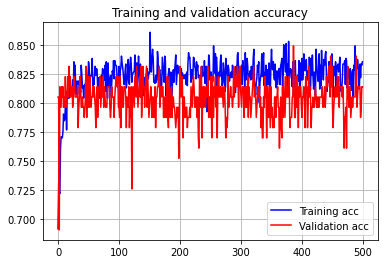

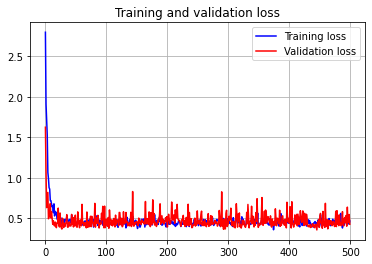

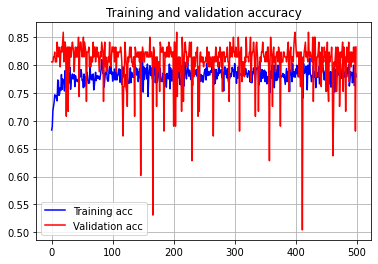

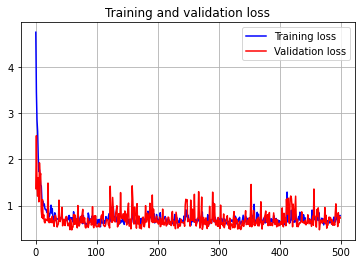

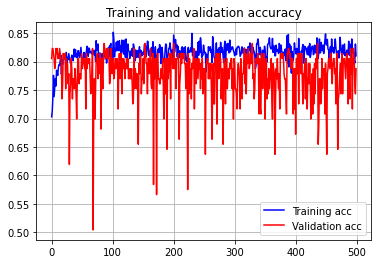

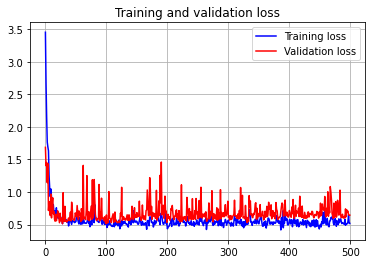

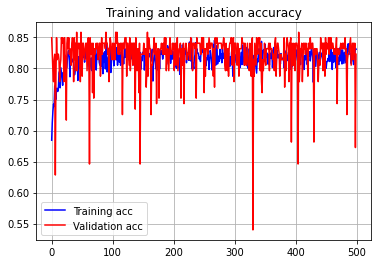

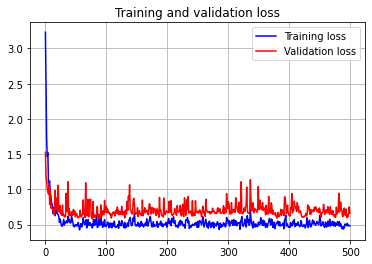

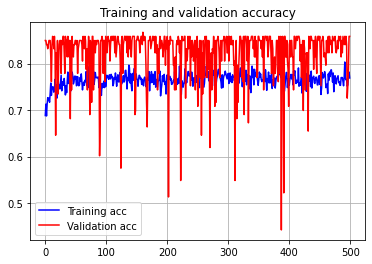

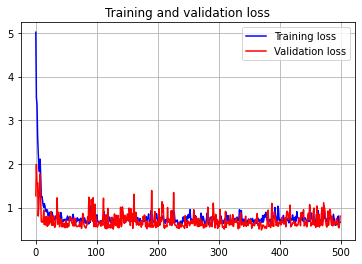

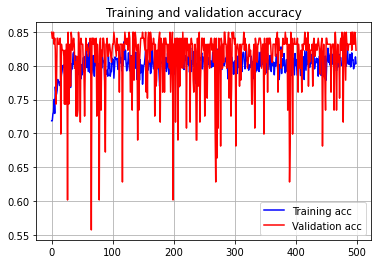

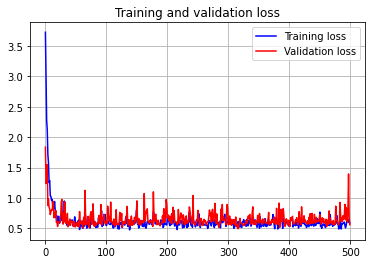

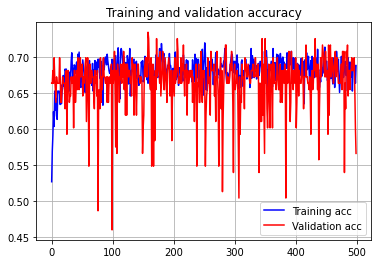

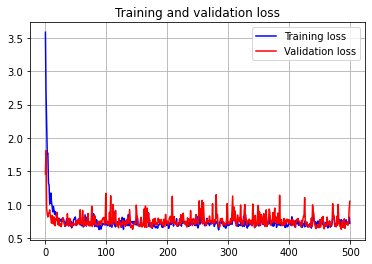

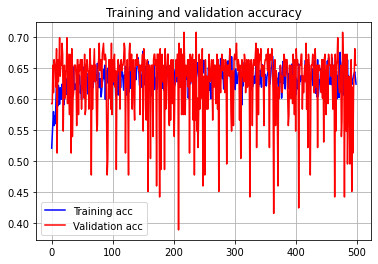

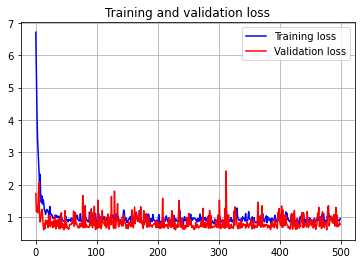

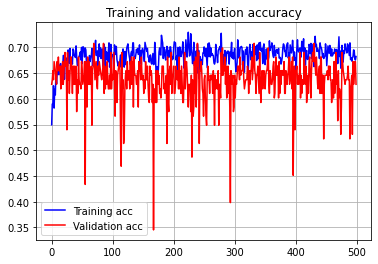

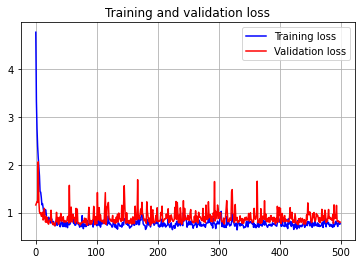

In [ ]:
plot_accuracy(ihistory_abnormal_sagittal)
plot_accuracy(ihistory_abnormal_coronal)
plot_accuracy(ihistory_abnormal_axial)

plot_accuracy(ihistory_acl_sagittal)
plot_accuracy(ihistory_acl_coronal)
plot_accuracy(ihistory_acl_axial)

plot_accuracy(ihistory_meniscus_sagittal)
plot_accuracy(ihistory_meniscus_coronal)
plot_accuracy(ihistory_meniscus_axial)

# DensetNet201

In [ ]:
from keras import models
from keras import layers
from keras.models import Model
from keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from keras.applications.inception_v3 import InceptionV3
from keras.applications.densenet import DenseNet201

def builddModel():
  d = DenseNet201(include_top=False, weights='imagenet', input_tensor=None, input_shape=(256,256,3), pooling=None)

  for layer in d.layers:
    layer.trainable = False

  x = d.output
  x = layers.GlobalAveragePooling2D()(x)
  x = layers.Dropout(0.6)(x)
  predictions = layers.Dense(1, activation= 'sigmoid')(x)
  model = Model(inputs = d.input, outputs = predictions)

  model.summary()

  model.compile(loss='binary_crossentropy',optimizer="adam",metrics=['accuracy'])
  return model

## Model Building & Testing For Abnormal

In [ ]:
dmodel_abnormal_sagittal = builddModel()
dhistory_abnormal_sagittal = dmodel_abnormal_sagittal.fit(sagittalData,abnormalLabels,epochs=500,validation_split=0.1, verbose=1,shuffle=True)

dmodel_abnormal_axial = builddModel()
dhistory_abnormal_axial = dmodel_abnormal_axial.fit(axialData,abnormalLabels,epochs=500,validation_split=0.1, verbose=1,shuffle=True)

dmodel_abnormal_coronal = builddModel()
dhistory_abnormal_coronal = dmodel_abnormal_coronal.fit(coronalData,abnormalLabels,epochs=500,validation_split=0.1, verbose=1,shuffle=True)

Streaming output truncated to the last 5000 lines.
conv2_block3_1_conv (Conv2D)    (None, 64, 64, 128)  16384       conv2_block3_0_relu[0][0]        
__________________________________________________________________________________________________
conv2_block3_1_bn (BatchNormali (None, 64, 64, 128)  512         conv2_block3_1_conv[0][0]        
__________________________________________________________________________________________________
conv2_block3_1_relu (Activation (None, 64, 64, 128)  0           conv2_block3_1_bn[0][0]          
__________________________________________________________________________________________________
conv2_block3_2_conv (Conv2D)    (None, 64, 64, 32)   36864       conv2_block3_1_relu[0][0]        
__________________________________________________________________________________________________
conv2_block3_concat (Concatenat (None, 64, 64, 160)  0           conv2_block2_concat[0][0]        
                                                          

## Model Building & Testing For ACL

In [ ]:
dmodel_acl_sagittal = builddModel()
dhistory_acl_sagittal = dmodel_acl_sagittal.fit(sagittalData,aclLabels,epochs=500,validation_split=0.1, verbose=1,shuffle=True)

dmodel_acl_axial = builddModel()
dhistory_acl_axial = dmodel_acl_axial.fit(axialData,aclLabels,epochs=500,validation_split=0.1, verbose=1,shuffle=True)

dmodel_acl_coronal = builddModel()
dhistory_acl_coronal = dmodel_acl_coronal.fit(coronalData,aclLabels,epochs=500,validation_split=0.1, verbose=1,shuffle=True)


Streaming output truncated to the last 5000 lines.
conv2_block3_1_conv (Conv2D)    (None, 64, 64, 128)  16384       conv2_block3_0_relu[0][0]        
__________________________________________________________________________________________________
conv2_block3_1_bn (BatchNormali (None, 64, 64, 128)  512         conv2_block3_1_conv[0][0]        
__________________________________________________________________________________________________
conv2_block3_1_relu (Activation (None, 64, 64, 128)  0           conv2_block3_1_bn[0][0]          
__________________________________________________________________________________________________
conv2_block3_2_conv (Conv2D)    (None, 64, 64, 32)   36864       conv2_block3_1_relu[0][0]        
__________________________________________________________________________________________________
conv2_block3_concat (Concatenat (None, 64, 64, 160)  0           conv2_block2_concat[0][0]        
                                                          

## Model Building & Testing For Meniscus

In [ ]:
dmodel_meniscus_sagittal = builddModel()
dhistory_meniscus_sagittal = dmodel_meniscus_sagittal.fit(sagittalData,meniscusLabels,epochs=500,validation_split=0.1, verbose=1,shuffle=True)

dmodel_meniscus_axial = builddModel()
dhistory_meniscus_axial = dmodel_meniscus_axial.fit(axialData,meniscusLabels,epochs=500,validation_split=0.1, verbose=1,shuffle=True)

dmodel_meniscus_coronal = builddModel()
dhistory_meniscus_coronal = dmodel_meniscus_coronal.fit(coronalData,meniscusLabels,epochs=500,validation_split=0.1, verbose=1,shuffle=True)


Streaming output truncated to the last 5000 lines.
conv2_block3_1_conv (Conv2D)    (None, 64, 64, 128)  16384       conv2_block3_0_relu[0][0]        
__________________________________________________________________________________________________
conv2_block3_1_bn (BatchNormali (None, 64, 64, 128)  512         conv2_block3_1_conv[0][0]        
__________________________________________________________________________________________________
conv2_block3_1_relu (Activation (None, 64, 64, 128)  0           conv2_block3_1_bn[0][0]          
__________________________________________________________________________________________________
conv2_block3_2_conv (Conv2D)    (None, 64, 64, 32)   36864       conv2_block3_1_relu[0][0]        
__________________________________________________________________________________________________
conv2_block3_concat (Concatenat (None, 64, 64, 160)  0           conv2_block2_concat[0][0]        
                                                          

## Testing Individual Class

In [ ]:
dpredictions_abnormal_sagittal = predictLabels(sagittalTestData,dmodel_abnormal_sagittal, 0.75)
print("---------------------------------------------------------------------------------")
dpredictions_abnormal_axial = predictLabels(axialTestData,dmodel_abnormal_axial, 0.75)
print("---------------------------------------------------------------------------------")
dpredictions_abnormal_coronal = predictLabels(coronalTestData,dmodel_abnormal_coronal, 0.75)

print("############################################")
dpredictions_acl_sagittal = predictLabels(sagittalTestData,dmodel_acl_sagittal, 0.15)
print("---------------------------------------------------------------------------------")
dpredictions_acl_axial = predictLabels(axialTestData,dmodel_acl_axial, 0.15)
print("---------------------------------------------------------------------------------")
dpredictions_acl_coronal = predictLabels(coronalTestData,dmodel_acl_coronal, 0.15)

print("############################################")
dpredictions_meniscus_sagittal = predictLabels(sagittalTestData,dmodel_meniscus_sagittal, 0.4)
print("---------------------------------------------------------------------------------")
dpredictions_meniscus_axial = predictLabels(axialTestData,dmodel_meniscus_axial, 0.4)
print("---------------------------------------------------------------------------------")
dpredictions_meniscus_coronal = predictLabels(coronalTestData,dmodel_meniscus_coronal, 0.4)

[0.7951441]
[0.6836324]
[0.14504524]
[0.05006471]
[0.86231405]
[0.8929252]
[0.9871114]
[0.9676301]
[0.9078735]
[0.6779438]
[0.82197577]
[0.89814883]
[0.7224718]
[0.740625]
[0.4408171]
[0.9535971]
[0.31570703]
[0.7051831]
[0.6836764]
[0.26881266]
[0.76579165]
[0.7173762]
[0.3648149]
[0.3740774]
[0.7369766]
[0.8775917]
[0.98480564]
[0.9541158]
[0.99611497]
[0.98758245]
[0.7565968]
[0.7231322]
[0.9952337]
[0.8232012]
[0.62858766]
[0.5613827]
[0.91252095]
[0.9375994]
[0.7755374]
[0.38777903]
[0.6713149]
[0.936252]
[0.80815685]
[0.88815445]
[0.81317294]
[0.9062683]
[0.89259076]
[0.9477672]
[0.9773401]
[0.78465444]
[0.99692506]
[0.89469856]
[0.95223373]
[0.9162108]
[0.9838283]
[0.8938963]
[0.9649643]
[0.99853003]
[0.93240416]
[0.8523291]
[0.92604965]
[0.9828333]
[0.7684366]
[0.9722897]
[0.98856735]
[0.985402]
[0.99631363]
[0.6672541]
[0.9085172]
[0.9595654]
[0.7011648]
[0.9120854]
[0.79188716]
[0.89761627]
[0.98437035]
[0.9605971]
[0.91208833]
[0.9355074]
[0.6326934]
[0.92143947]
[0.950203]


## Final Prediction

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
def ensemble(predictions1,predictions2,predictions3):
  list=[]
  for i in range(0,len(predictions1),1):
    total = sum([predictions1[i],predictions2[i],predictions3[i]])
    if total > 1:
      list.append(1)
    else:
      list.append(0)
      
  return list.copy()

dlabels_abnormal_ensemble = ensemble(dpredictions_abnormal_sagittal,dpredictions_abnormal_axial,dpredictions_abnormal_coronal)
print("labels_abnormal_ensemble: ",dlabels_abnormal_ensemble)
dscore_abnormal = getEvaluationScore(abnornmalTestLabels, dlabels_abnormal_ensemble)


dlabels_acl_ensemble = ensemble(dpredictions_acl_sagittal,dpredictions_acl_axial,dpredictions_acl_coronal)
print("labels_acl_ensemble: ",dlabels_acl_ensemble)
dscore_acl = getEvaluationScore(aclTestLabels, dlabels_acl_ensemble)



dlabels_meniscus_ensemble = ensemble(dpredictions_meniscus_sagittal,dpredictions_meniscus_axial,dpredictions_meniscus_coronal)
print("labels_meniscus_ensemble: ",dlabels_meniscus_ensemble)
dscore_meniscus = getEvaluationScore(meniscusTestLabels, dlabels_meniscus_ensemble)

labels_abnormal_ensemble:  [1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0]
my score:  0.7333333333333333
fscore:  0.8222222222222222
labels_acl_ensemble:  [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1]
my score:  0.7416666666666667
fscore:  0.6868686868686867
labels_meniscus_ensemble:  [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1

In [ ]:
score1 = getEvaluationScore(abnornmalTestLabels, dpredictions_abnormal_sagittal)
score2 = getEvaluationScore(abnornmalTestLabels, dpredictions_abnormal_axial)
score3 = getEvaluationScore(abnornmalTestLabels, dpredictions_abnormal_coronal)

my score:  0.8083333333333333
fscore:  0.8783068783068785
my score:  0.6416666666666667
fscore:  0.7225806451612904
my score:  0.7
fscore:  0.8021978021978021


In [ ]:
score1 = getEvaluationScore(aclTestLabels, dpredictions_acl_sagittal)
score2 = getEvaluationScore(aclTestLabels, dpredictions_acl_axial)
score3 = getEvaluationScore(aclTestLabels, dpredictions_acl_coronal)

my score:  0.7
fscore:  0.7187499999999999
my score:  0.7416666666666667
fscore:  0.6265060240963856
my score:  0.6
fscore:  0.4418604651162791


In [ ]:
score1 = getEvaluationScore(meniscusTestLabels, dpredictions_meniscus_sagittal)
score2 = getEvaluationScore(meniscusTestLabels, dpredictions_meniscus_axial)
score3 = getEvaluationScore(meniscusTestLabels, dpredictions_meniscus_coronal)

my score:  0.6666666666666666
fscore:  0.6363636363636364
my score:  0.6166666666666667
fscore:  0.43902439024390244
my score:  0.6166666666666667
fscore:  0.4772727272727273


## Training Acc & Loss Graphs

In [ ]:
def plot_accuracy(history):  
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'b', label='Training acc')
  plt.plot(epochs, val_acc, 'r', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.grid(True)

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()
  plt.grid(True)
  plt.show()

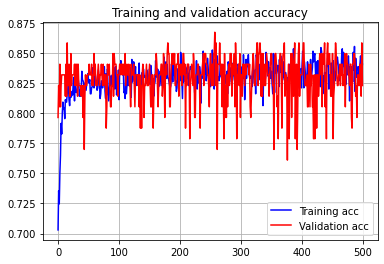

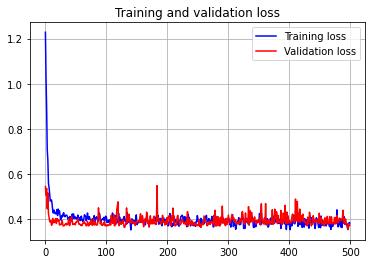

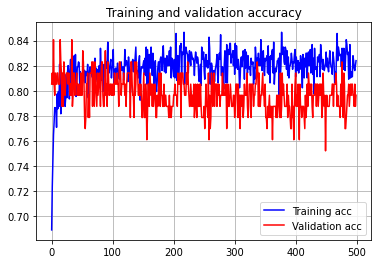

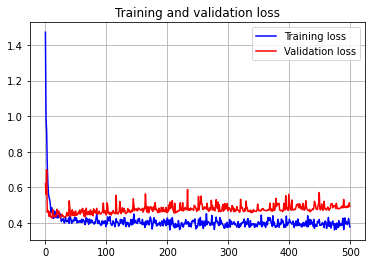

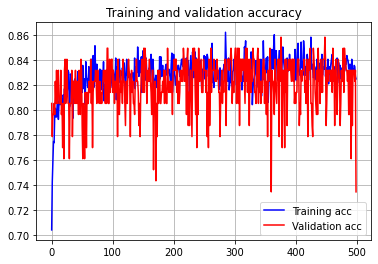

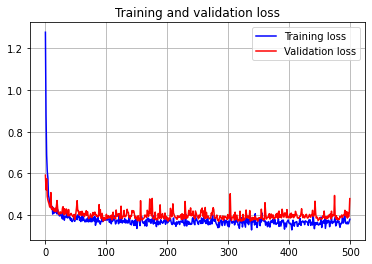

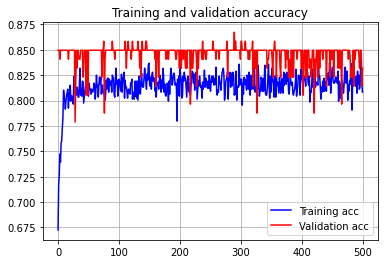

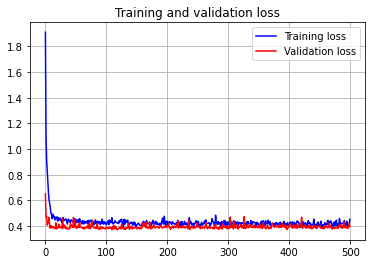

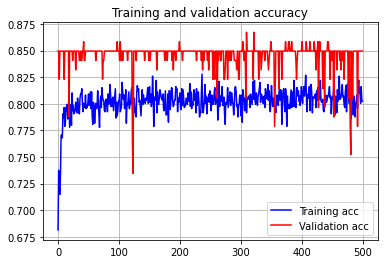

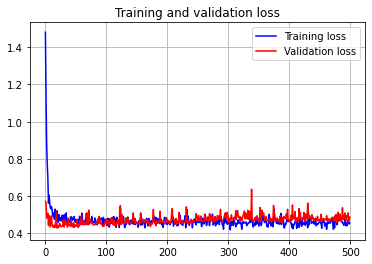

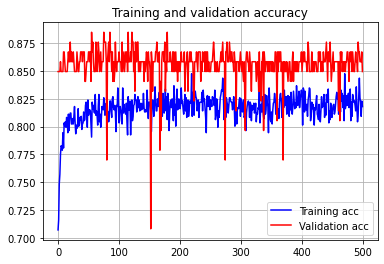

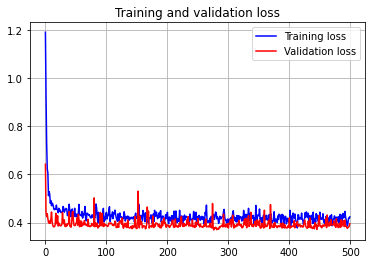

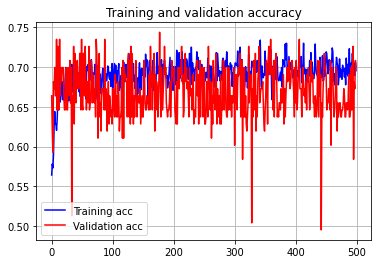

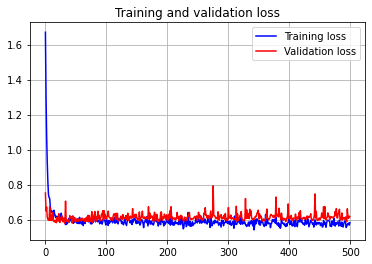

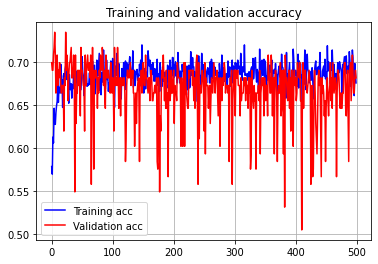

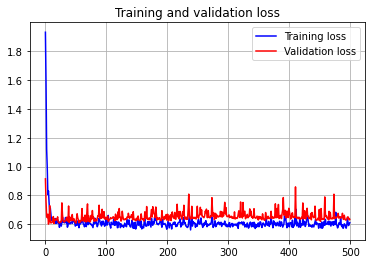

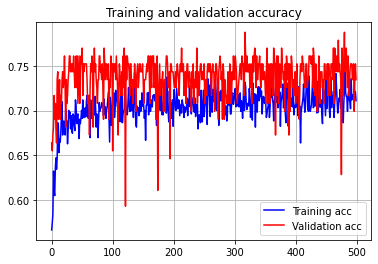

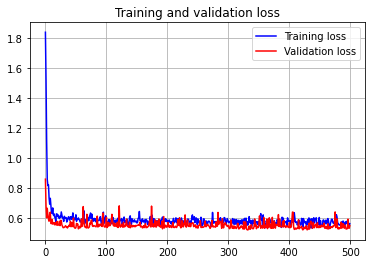

In [ ]:
plot_accuracy(dhistory_abnormal_sagittal)
plot_accuracy(dhistory_abnormal_coronal)
plot_accuracy(dhistory_abnormal_axial)

plot_accuracy(dhistory_acl_sagittal)
plot_accuracy(dhistory_acl_coronal)
plot_accuracy(dhistory_acl_axial)

plot_accuracy(dhistory_meniscus_sagittal)
plot_accuracy(dhistory_meniscus_coronal)
plot_accuracy(dhistory_meniscus_axial)